In [97]:
import numpy as np
import open3d as o3d

# %matplotlib inline
# %config InlineBackend.figure_format = 'svg'

import matplotlib
import matplotlib.pyplot as plt
import warnings
import os
import re
import joblib
import os.path as osp

from tqdm import  tqdm
from radar_preprocess.radar_dataclass import *
from natsort import natsorted
from radar_preprocess.radar_data_preprocess import RadarData
from typing import List, Dict


plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'

warnings.filterwarnings('ignore')

# Temploral align

In [98]:
LIDAR_FILE_ROOT_PATH = '/Users/austin/Downloads/VRFusion/lidar/chengdu-2025-02-26/data'
RADAR_FILE_ROOT_PATH = '/Users/austin/Downloads/VRFusion/radar/chengdu-2025-02-26/json'

In [99]:
import os
import re
from natsort import natsorted
import numpy as np


def extract_timestamp(filename):
    match = re.search(r'(\d+\.\d+)', filename)
    if match:
        return float(match.group(1))
    return None

def extract_timestamp_json(filename):
    match = re.search(r'(\d+\_\d+)', filename)
    if match:
        return float(match.group(1)) / 1000
    return None

lidar_file_list = natsorted(os.listdir(LIDAR_FILE_ROOT_PATH))
radar_file_list = natsorted(os.listdir(RADAR_FILE_ROOT_PATH))

lidar_file_list = [f for f in lidar_file_list if f.endswith('.pcd')]
radar_file_list = [f for f in radar_file_list if f.endswith('.json')]

pcd_files  = sorted(lidar_file_list, key=lambda x: extract_timestamp(x))
json_files = sorted(radar_file_list, key=lambda x: extract_timestamp_json(x))

aligned_data_dict = dict()

lidar_align_list = list()
radar_align_list = list()

for pcd_file in pcd_files:
    pcd_timestamp = extract_timestamp(pcd_file)
    closest_json_file = None
    min_time_diff = float('inf')

    for json_file in json_files:
        json_timestamp = extract_timestamp_json(json_file)
        time_diff = abs(pcd_timestamp - json_timestamp)

        if time_diff < min_time_diff:
            min_time_diff = time_diff
            closest_json_file = json_file

    if closest_json_file:
        aligned_data_dict[pcd_file] = closest_json_file

        lidar_align_list.append(osp.join(LIDAR_FILE_ROOT_PATH, pcd_file))
        radar_align_list.append(osp.join(RADAR_FILE_ROOT_PATH, closest_json_file))

# for pcd_file in aligned_data_dict:
#     print(f'PCD File: {pcd_file} -> JSON File: {aligned_data_dict[pcd_file]}')

aligned_data_path = '/Users/austin/Downloads/VRFusion/result/aligned_data'

joblib.dump([lidar_align_list,radar_align_list ], 
            osp.join(aligned_data_path, 
                     LIDAR_FILE_ROOT_PATH.split('/')[6] + ':lidar_radar_temploral_aligned_data.list'))

['/Users/austin/Downloads/VRFusion/result/aligned_data/chengdu-2025-02-26:lidar_radar_temploral_aligned_data.list']

In [100]:
temporal_aligned_data = joblib.load('/Users/austin/Downloads/VRFusion/result/aligned_data/chengdu-2025-02-26:lidar_radar_temploral_aligned_data.list')
print('\'{}\''.format(temporal_aligned_data[0][0]))
print('\'{}\''.format(temporal_aligned_data[1][0]))

'/Users/austin/Downloads/VRFusion/lidar/chengdu-2025-02-26/data/1740546244.765178000.pcd'
'/Users/austin/Downloads/VRFusion/radar/chengdu-2025-02-26/json/1740546244_753.json'


# Spatial align

In [101]:
LIDAR_FILE_PATH = '/Users/austin/Downloads/VRFusion/lidar/chengdu-2025-02-26/data/1740546244.765178000.pcd'
RADAR_FILE_PATH = '/Users/austin/Downloads/VRFusion/radar/chengdu-2025-02-26/json/1740546244_753.json'

In [102]:
data = RadarData(root_path=RADAR_FILE_ROOT_PATH, duration_frames=1)
dets_list: List[detections] = data.read_single_frame(data_file_path=RADAR_FILE_PATH).dets.det_list

Loading raw RADAR frames...: 100%|██████████| 1/1 [00:00<00:00, 12.40it/s]


In [103]:
dets_array = np.array([np.array([det.add_pos_x, det.add_pos_y]) for det in dets_list])

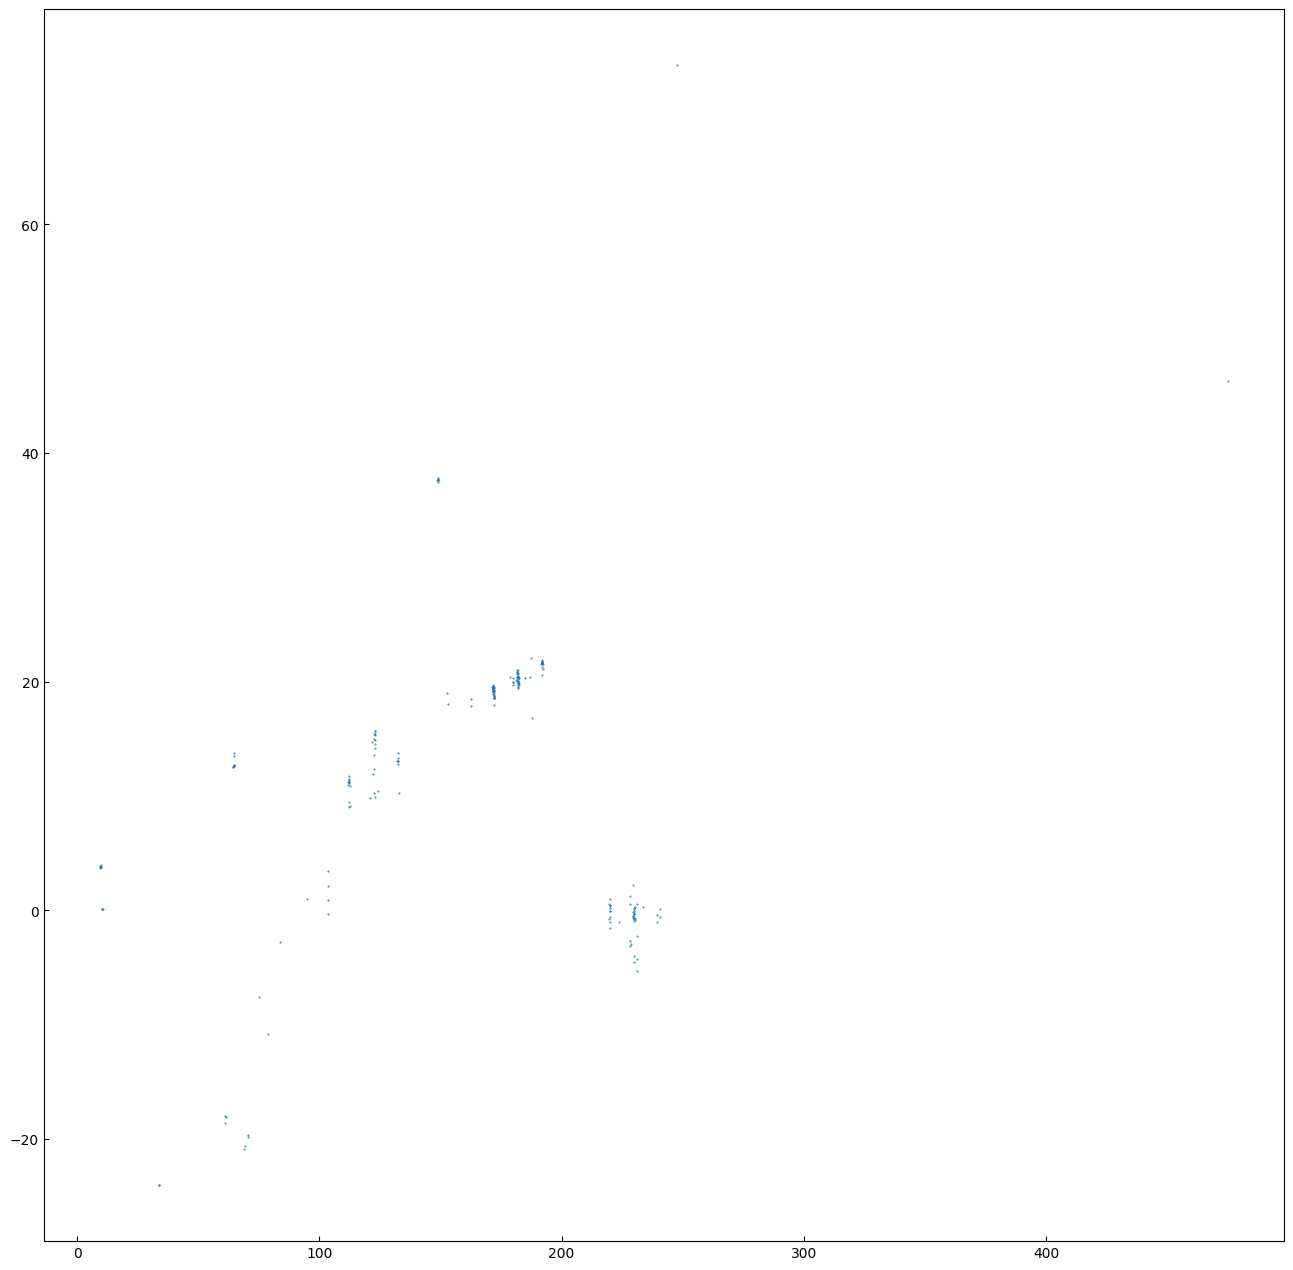

In [104]:
plt.figure(figsize=(16, 16))
plt.scatter(dets_array[:, 0], dets_array[:, 1], s=0.2)

In [105]:
def load_pcd(file_path):
    # 使用 open3d 读取二进制格式的 PCD 文件
    pcd = o3d.io.read_point_cloud(file_path)
    points = np.asarray(pcd.points)
    return points

In [106]:
lidar_point_clounds = load_pcd(LIDAR_FILE_PATH)

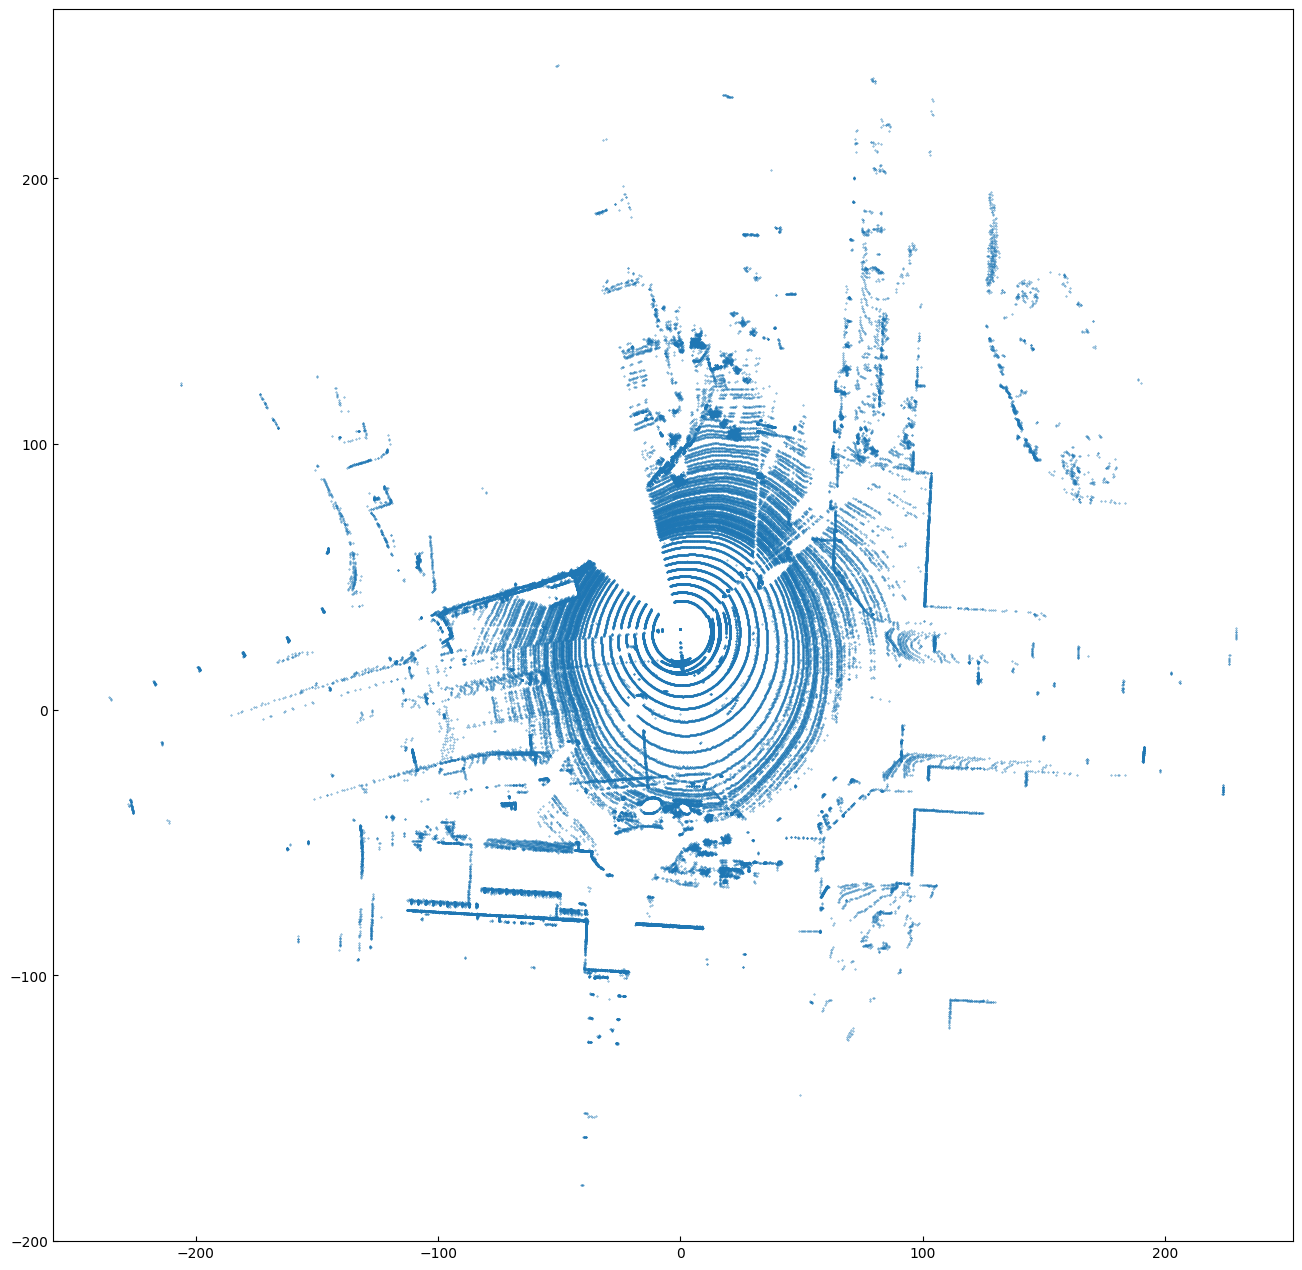

In [107]:
plt.figure(figsize=(16, 16))
plt.scatter(lidar_point_clounds[:, 0], lidar_point_clounds[:, 1], s=0.1)

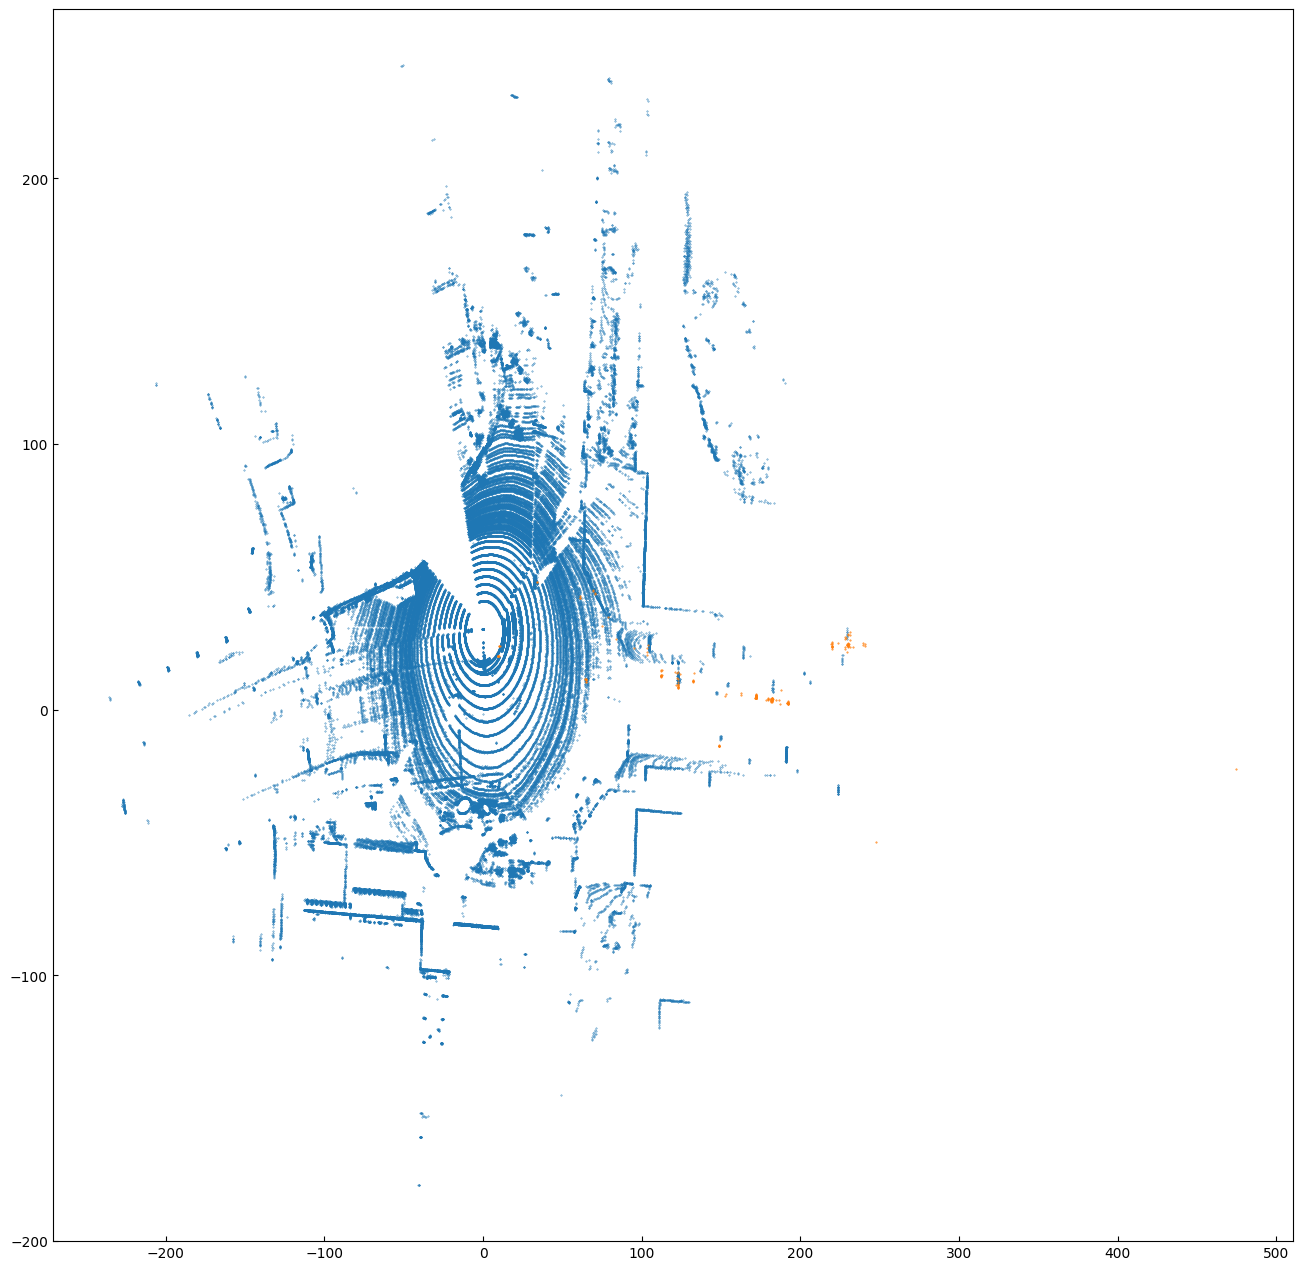

In [108]:
plt.figure(figsize=(16, 16))
plt.scatter(lidar_point_clounds[:, 0], lidar_point_clounds[:, 1], s=0.1)
plt.scatter(dets_array[:, 0], -dets_array[:, 1]+24, s=0.2)